In [ ]:
!pip install torch torchvision tensorboard torchmetrics
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 45.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

Import Libraries

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet18
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
import glob
import torch.onnx
import onnx
import os

Load CIFAR-100 Dataset

In [ ]:
# Define data transformations
transform = transforms.Compose([
    # Todo add other types of augmentation
    transforms.RandomHorizontalFlip(),  # Add horizontal flipping
    transforms.RandomRotation(10),     # Add random rotations (up to 10 degrees)
    transforms.RandomCrop(32, padding=4),  # Add random cropping with padding
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))  # CIFAR-100 normalization values
])

# Load CIFAR-100 dataset
batch_size = 64
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# Define the model
model = resnet18(pretrained=True)  # Set num_classes to 100 for CIFAR-100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device) # set the model on cuda
model.fc = nn.Linear(model.fc.in_features, 100)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc.parameters(), lr=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=5e-4)



# Function to save a checkpoint in the TensorBoard log directory
def save_checkpoint(model, optimizer, epoch, loss_metric, accuracy_metric, checkpoint_dir='runs/cifar100_resnet18'):
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = f"{checkpoint_dir}/checkpoint_epoch_{epoch+1}.pth"

    # Use .compute() to get the values of the metrics
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss_metric.compute(),  # Get the computed loss
        'accuracy': accuracy_metric.compute()  # Get the computed accuracy
    }
    torch.save(checkpoint, checkpoint_path)
    print(f'Checkpoint saved at {checkpoint_path}')

# Function to load a checkpoint from the TensorBoard log directory
def load_checkpoint(model, optimizer, checkpoint_dir='runs/cifar100_resnet18'):
    # Find the latest checkpoint (e.g., based on the highest epoch number)
    checkpoint_paths = glob.glob(f"{checkpoint_dir}/checkpoint_epoch_*.pth")
    checkpoint_paths.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
    latest_checkpoint = checkpoint_paths[-1]

    checkpoint = torch.load(latest_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
    loss = checkpoint['loss']
    accuracy = checkpoint['accuracy']
    print(f'Checkpoint loaded from {latest_checkpoint}. Resuming training from epoch {start_epoch}')

    return start_epoch, loss, accuracy  # You can return these for reference but don't update accuracy_metric with them




# Updated training function with torchmetrics and resuming capability
def train_model(model, train_loader, criterion, optimizer, num_epochs=1, start_epoch=0, resume=False, checkpoint_dir='runs/cifar100_resnet18'):
    # Initialize the metrics
    loss_metric = torchmetrics.MeanMetric().to(device)
    accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=100).to(device)

    # Load checkpoint if resuming
    if resume:
        start_epoch, loss, accuracy = load_checkpoint(model, optimizer, checkpoint_dir='runs/cifar100_resnet18')
        loss_metric.update(torch.tensor(loss))

    model.train()
    for epoch in range(start_epoch, num_epochs):
        loss_metric.reset()
        accuracy_metric.reset()
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_metric.update(loss.item())
            accuracy_metric.update(outputs, labels)
            if i%100 == 0:
              avg_loss = loss_metric.compute().item()
              avg_acc = accuracy_metric.compute().item()
              avg_acc = avg_acc * 100
              print(f"Epoch [{epoch}]: Loss={avg_loss}, Accuracy={avg_acc:.2f}")

        save_checkpoint(model, optimizer, epoch, loss_metric, accuracy_metric, checkpoint_dir='runs/cifar100_resnet18')


def evaluate_model(model, test_loader, criterion, optimizer, checkpoint_dir='runs/cifar100_resnet18'):
    # Load the model from the latest checkpoint if needed
    load_checkpoint(model, optimizer, checkpoint_dir)

    loss_metric = torchmetrics.MeanMetric().to(device)
    accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=100).to(device)

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss_metric.update(loss.item())
            accuracy_metric.update(outputs, labels)

        avg_loss = loss_metric.compute()
        avg_acc = accuracy_metric.compute()

        return avg_loss, avg_acc*100

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def get_incorrect_predictions(model, loader, max_samples=10):
    model.eval()
    incorrect_samples = []
    incorrect_labels = []
    incorrect_preds = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            incorrect_indices = (preds != labels).nonzero(as_tuple=True)[0]

            for idx in incorrect_indices:
              if len(incorrect_samples) < max_samples:
                incorrect_samples.append(inputs[idx].cpu())
                incorrect_labels.append(labels[idx].cpu().item())
                incorrect_preds.append(preds[idx].cpu().item())
              else:
                return incorrect_samples, incorrect_labels, incorrect_preds


    return incorrect_samples, incorrect_labels, incorrect_preds


def visualize_incorrect_predictions(model, loader, class_names, max_samples=10):
    incorrect_samples, incorrect_labels, incorrect_preds = get_incorrect_predictions(model, loader, max_samples=max_samples)

    # Plot the images with true and predicted labels
    fig, axes = plt.subplots(1, len(incorrect_samples), figsize=(15, 5))
    if len(incorrect_samples) == 1:
        axes = [axes]  # To handle the case where there's only one incorrect sample

    for idx, (img, true_label, pred_label) in enumerate(zip(incorrect_samples, incorrect_labels, incorrect_preds)):
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = img * 0.2673 + 0.5071  # Unnormalize for CIFAR100: (std_dev * image + mean)
        img = np.clip(img, 0, 1)

        axes[idx].imshow(img)
        axes[idx].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}', fontsize=10)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def get_correct_predictions(model, loader, max_samples=10):
    model.eval()
    correct_samples = []
    correct_labels = []
    correct_preds = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            correct_indices = (preds == labels).nonzero(as_tuple=True)[0]

            for idx in correct_indices:
                if len(correct_samples) < max_samples:
                    correct_samples.append(inputs[idx].cpu())
                    correct_labels.append(labels[idx].cpu().item())
                    correct_preds.append(preds[idx].cpu().item())
                else:
                    return correct_samples, correct_labels, correct_preds

    return correct_samples, correct_labels, correct_preds


def visualize_correct_predictions(model, loader, class_names, max_samples=10):
    correct_samples, correct_labels, correct_preds = get_correct_predictions(
        model, loader, max_samples=max_samples
    )

    fig, axes = plt.subplots(1, len(correct_samples), figsize=(15, 5))
    if len(correct_samples) == 1:
        axes = [axes]

    for idx, (img, true_label, pred_label) in enumerate(
        zip(correct_samples, correct_labels, correct_preds)
    ):
        img = img.permute(1, 2, 0)
        img = img * 0.2673 + 0.5071  # Unnormalize for CIFAR100
        img = np.clip(img, 0, 1)

        axes[idx].imshow(img)
        axes[idx].set_title(
            f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
            fontsize=10,
        )
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
train_model(model, train_loader, criterion, optimizer, num_epochs=100, resume=True, checkpoint_dir='runs/cifar100_resnet18')

<ipython-input-10-31a354a8536d>:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(latest_checkpoint)
<ipython-input-10-31a354a8536d>:80: UserWarning:

Checkpoint loaded from runs/cifar100_resnet18/checkpoint_epoch_57.pth. Resuming training from epoch 57
Epoch [57]: Loss=0.2976227104663849, Accuracy=93.75
Epoch [57]: Loss=0.36470827460289, Accuracy=88.71
Epoch [57]: Loss=0.35645538568496704, Accuracy=89.14
Epoch [57]: Loss=0.3530927002429962, Accuracy=89.16
Epoch [57]: Loss=0.3578854501247406, Accuracy=88.91
Epoch [57]: Loss=0.3569960594177246, Accuracy=88.97
Epoch [57]: Loss=0.36042770743370056, Accuracy=88.86
Epoch [57]: Loss=0.36615243554115295, Accuracy=88.63
Checkpoint saved at runs/cifar100_resnet18/checkpoint_epoch_58.pth
Epoch [58]: Loss=0.48156508803367615, Accuracy=81.25
Epoch [58]: Loss=0.3238511085510254, Accuracy=90.13
Epoch [58]: Loss=0.3251429796218872, Accuracy=89.96
Epoch [58]: Loss=0.3267899453639984, Accuracy=90.00
Epoch [58]: Loss=0.33532124757766724, Accuracy=89.72
Epoch [58]: Loss=0.34091827273368835, Accuracy=89.50
Epoch [58]: Loss=0.3440019190311432, Accuracy=89.39
Epoch [58]: Loss=0.3461785316467285, Accuracy=

In [ ]:
train_model(model, train_loader, criterion, optimizer, num_epochs=20, resume=False, checkpoint_dir='runs/cifar100_resnet18')

Epoch [0]: Loss=5.211114406585693, Accuracy=0.00
Epoch [0]: Loss=4.327159404754639, Accuracy=7.47
Epoch [0]: Loss=3.9809067249298096, Accuracy=12.05
Epoch [0]: Loss=3.7504050731658936, Accuracy=15.03
Epoch [0]: Loss=3.5945613384246826, Accuracy=17.14
Epoch [0]: Loss=3.45626163482666, Accuracy=19.04
Epoch [0]: Loss=3.3476288318634033, Accuracy=20.68
Epoch [0]: Loss=3.2587926387786865, Accuracy=22.18
Checkpoint saved at runs/cifar100_resnet18/checkpoint_epoch_1.pth
Epoch [1]: Loss=2.847480535507202, Accuracy=29.69
Epoch [1]: Loss=2.4740517139434814, Accuracy=35.49
Epoch [1]: Loss=2.4774110317230225, Accuracy=35.39
Epoch [1]: Loss=2.4623324871063232, Accuracy=35.55
Epoch [1]: Loss=2.440190076828003, Accuracy=36.05
Epoch [1]: Loss=2.4262757301330566, Accuracy=36.47
Epoch [1]: Loss=2.409522533416748, Accuracy=36.95
Epoch [1]: Loss=2.389503240585327, Accuracy=37.38
Checkpoint saved at runs/cifar100_resnet18/checkpoint_epoch_2.pth
Epoch [2]: Loss=2.300192356109619, Accuracy=42.19
Epoch [2]: L

In [ ]:
evaluate_model(model, test_loader, criterion, optimizer, checkpoint_dir='runs/cifar100_resnet18')

<ipython-input-10-31a354a8536d>:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(latest_checkpoint)


Checkpoint loaded from runs/cifar100_resnet18/checkpoint_epoch_20.pth. Resuming training from epoch 20


(tensor(1.7879, device='cuda:0'), tensor(53.7500, device='cuda:0'))

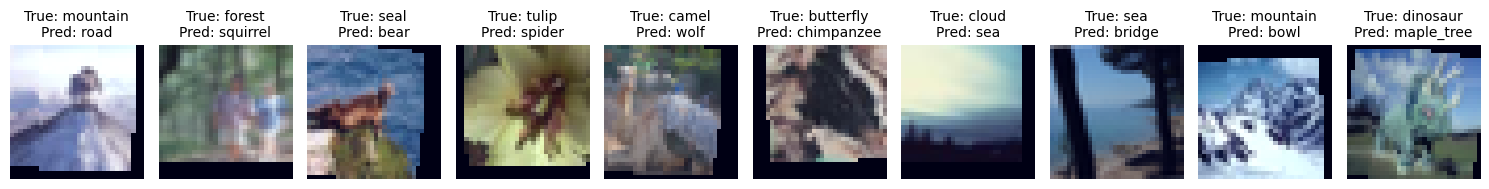

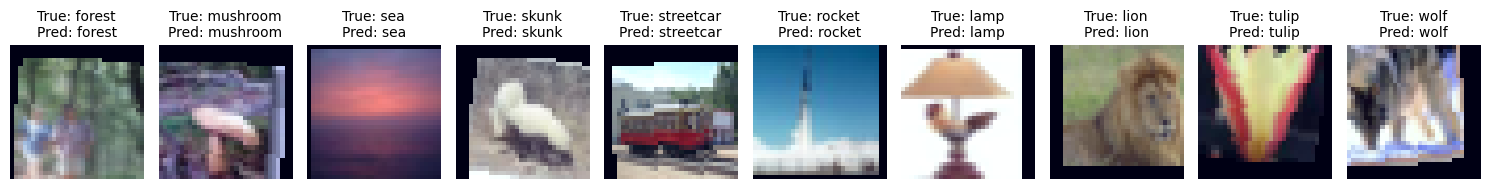

In [ ]:
class_names=train_dataset.classes
visualize_incorrect_predictions(model, test_loader, class_names, max_samples=10)
visualize_correct_predictions(model, test_loader, class_names, max_samples=10)

In [ ]:
# Assuming your model is loaded and named 'model'
# Assuming a sample input to the model is 'dummy_input'

# Create a sample input tensor
dummy_input = torch.randn(1, 3, 32, 32, device=device) # Assuming your input is a 3x32x32 image

# Export the model
torch.onnx.export(model,               # Your PyTorch model
                  dummy_input,        # A sample input to the model
                  "cifar100_resnet18_opset12.onnx",  # Output ONNX filename
                  verbose=True,       # Set to True for detailed output
                  opset_version=12)  # Specify the opset version

# Check the ONNX model
onnx_model = onnx.load("cifar100_resnet18_opset12.onnx")
onnx.checker.check_model(onnx_model)
print("ONNX model export successful and verified!")

ONNX model export successful and verified!


In [ ]:
from PIL import Image
import torchvision.transforms as transforms

CIFAR100_LABELS = {
    0: "apple", 1: "aquarium_fish", 2: "baby", 3: "bear", 4: "beaver",
    5: "bed", 6: "bee", 7: "beetle", 8: "bicycle", 9: "bottle",
    10: "bowl", 11: "boy", 12: "bridge", 13: "bus", 14: "butterfly",
    15: "camel", 16: "can", 17: "castle", 18: "caterpillar", 19: "cattle",
    20: "chair", 21: "chimpanzee", 22: "clock", 23: "cloud", 24: "cockroach",
    25: "couch", 26: "crab", 27: "crocodile", 28: "cup", 29: "dinosaur",
    30: "dolphin", 31: "elephant", 32: "flatfish", 33: "forest", 34: "fox",
    35: "girl", 36: "hamster", 37: "house", 38: "kangaroo", 39: "keyboard",
    40: "lamp", 41: "lawn_mower", 42: "leopard", 43: "lion", 44: "lizard",
    45: "lobster", 46: "man", 47: "maple_tree", 48: "motorcycle", 49: "mountain",
    50: "mouse", 51: "mushroom", 52: "oak_tree", 53: "orange", 54: "orchid",
    55: "otter", 56: "palm_tree", 57: "pear", 58: "pickup_truck", 59: "pine_tree",
    60: "plain", 61: "plate", 62: "poppy", 63: "porcupine", 64: "possum",
    65: "rabbit", 66: "raccoon", 67: "ray", 68: "road", 69: "rocket",
    70: "rose", 71: "sea", 72: "seal", 73: "shark", 74: "shrew",
    75: "skunk", 76: "skyscraper", 77: "snail", 78: "snake", 79: "spider",
    80: "squirrel", 81: "streetcar", 82: "sunflower", 83: "sweet_pepper", 84: "table",
    85: "tank", 86: "telephone", 87: "television", 88: "tiger", 89: "tractor",
    90: "train", 91: "trout", 92: "tulip", 93: "turtle", 94: "wardrobe",
    95: "whale", 96: "willow_tree", 97: "wolf", 98: "woman", 99: "worm"
}

def predict_local(image_path, model_path):
    # Load the trained model
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 100)  # Adjust for CIFAR-100
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Preprocess the image
    transform = transforms.Compose([
        transforms.Resize(32),  # Resize to match CIFAR-100 input size
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))  # CIFAR-100 normalization values
    ])
    image = Image.open(image_path).convert('RGB')  # Ensure RGB format
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Make the prediction
    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)

    # Get the class name
    predicted_class_name = CIFAR100_LABELS[predicted_class.item()]

    return predicted_class_name

# Define local paths
image_path = "/content/cat.jpg"  # Replace with actual image path
model_path = "/content/runs/cifar100_resnet18/checkpoint_epoch_57.pth"  # Replace with actual model path

# Run local prediction
predict_local(image_path, model_path)

<ipython-input-40-3943c5476195>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


'cattle'